Testing various AIs with various lookup-table "value" functions on tic-tac-toe

In [7]:
import numpy as np 
import random

Hashes out all possible board trajectories, then grades them.
Working backwards from all finished states (with either 0, 0.5, or 1 grade), for any non-finished
state, assigns maximum value of all possible future moves if my turn, minimum value if
opponent's turn.

The function assumes that it's "symbol"'s turn.

Speed: O(n!) where n is # of slots -> ~O(3^n) with dynamic programming to make a full lookup table

Simplicity: idk, took ~an hour for me to code up

In [8]:
utilities = {}
def utility(board: np.array, symbol, opp_symbol) -> int:
    #print(board)
    init_score = grade_board(board)
    if init_score != -1:
        return init_score
    
    all_traj = []
    for row in range(3):
        for col in range(3):
            if board[row][col] == 0:
                board_copy = np.copy(board)
                board_copy[row][col] = symbol
                all_traj.append(board_copy)
    
    grades = []
    for traj in all_traj:
        key = (traj.tobytes(), opp_symbol)
        if not (key in utilities.keys()):
            utilities[key] = utility(traj, opp_symbol, symbol)
        grades.append(utilities[key])
    # grades = [utility(traj, opp_symbol, symbol) for traj in all_traj]
    #print(all_traj)
    #print(grades)
    if symbol in grades:
        return symbol
    if 0.5 in grades:
        return 0.5
    return opp_symbol

"""
Grades a board -- either the winner, 0.5 if draw, or -1 if not finished
(given one player is 1, the other is 2)
Inspiration: https://gist.github.com/qianguigui1104/edb3b11b33c78e5894aad7908c773353 
"""
def grade_board(board: np.array):
    for row in range(3):
        if board[row][0] == board[row][1] == board[row][2] and board[row][0] != 0:
            return board[row][0]
    for col in range(3):
        if board[0][col] == board[1][col] == board[2][col] and board[0][col] != 0:
            return board[0][col]
        
    if board[0][0] == board[1][1] == board[2][2] and board[0][0] != 0:
        return board[0][0]
    if board[0][2] == board[1][1] == board[2][0] and board[0][2] != 0:
        return board[0][2]
    
    full = True
    for row in range(3):
        for col in range(3):
            if board[row][col] == 0:
                full = False
    if full:
        return 0.5
    return -1

def hash(board, symbol) -> int:
    out = 0
    primes = [2, 3, 5, 7, 11, 13, 17, 19, 23]
    for row in range(3):
        for col in range(3):
            out += primes[3*row + col] * board[row][col]
    out += 29 * symbol
    return

print(utility(np.zeros((3, 3)), 1, 2)) #expected: 0.5
print(len(utilities))
print(utility(np.array([[1, 0, 1], [2, 2, 0], [1, 0, 2]]), 1, 2)) 
#X _ X | O O _ | X _ O; expected: 1
print(utility(np.array([[1, 0, 0], [0, 2, 0], [0, 0, 0]]), 1, 2))
#X _ _ | _ O _ | _ _ _; expected: 0.5

0.5
5477
1
0.5


Is this a utility function model or a value model? The recursion part might make it a value model,
but we're also effectively using brute-force here (the only "heuristic" here is end-game score).

What would a reward/value lookup table for tic-tac-toe look like? 
- If there's two-in-a-row of our symbol and the other spot is blank, max reward (we can win on the next turn)
- If there's two-in-a-row of their symbol and the other spot is blank, all moves besides filling that blank spot have min reward
- If we have the opportunity to create a "fork" (a setup where we have two symbols in two different row/column/diagonals, making it impossible for the opponent to stop us next turn from winning), max reward
- Otherwise, maybe having zero opp_symbol and >= 1 symbol in a row/column/diagonal is positive reward?
    - Maybe having a symbol in a corner or the center is good
    - These don't seem very meaningful/indicative of anything, and are harder to code up

e.g. see https://github.com/SamarpanCoder2002/Tic-Tac-Toe-AI/blob/main/Tic-Tac-Toe-AI.py for a heuristics AI (~430 lines!)

Heuristics: see https://blog.ostermiller.org/tic-tac-toe-strategy/ for an example

Notable points:
- Value/Reward looks simliar to utility in returning a number, but doesn't do recursion
- In return, grade_board has to be more complicated (act() is simpler than utility())

In [9]:
#Value/Reward -- O(n) * (runtime of grade_board) where n = # cells
def act(board, symbol, opp_symbol) -> tuple:
    init_score = grade_board(board, symbol, opp_symbol)
    if init_score == 0 or init_score == 1: #game is over
        return init_score
    
    all_traj = []
    moves = []
    for row in range(3):
        for col in range(3):
            if board[row][col] == 0:
                board_copy = np.copy(board)
                board_copy[row][col] = symbol
                all_traj.append(board_copy)
                moves.append((row, col))
    
    grades = [grade_board(traj, opp_symbol, symbol) for traj in all_traj]
    #grades contains reward/value for each possible move
    if symbol in grades:
        return symbol
    return moves[grades.index(min(grades))] #tuple resulting in the worst position for the opponent

#Calculates reward/value
def grade_board(board: np.array, symbol, opp_symbol):
    """
    Pseudocode:
    for all one move trajectories, resulting in new_board:
        assign rewards to notable differences (e.g. if move resulted in two-in-a-row)
        sum rewards
    return sum
    """
    return np.random.rand()


print(act(np.zeros((3, 3)), 1, 2))

(1, 0)


Claim: there exists a structure w/n NN (e.g. some Python function) that can be described as one of these non-degenerately (where non-degenerate <-> predictive OOD)

ex: chess
- Utility: {all possible set of moves} -> {0, 0.5, 1}
- Reward: -3 pts if lose knight, etc.
- Value: rating the “total value” of the current board (e.g. by summing up all the values of the pieces; this would produce a pretty bad chess AI, but not that bad)
- Heuristics: e.g. if Sicilian, play 5… a6

In this case, the code becomes more "complicated", harder to write and harder to interpret as we sacrifice more speed. If we change the game a little bit (e.g. make it so that each player can place 1s or 2s; the first player to get three-in-a-row of either symbol wins), the heuristics will also fail to generalize, whereas a small modification to the grade_board and/or utility function will result in the utility function working. (You do have to carefully modify grade_board, though; I guess in some sense, we use the heuristic that we are in a 3x3 board, only 1s and 2s are played, etc.)

In [10]:
#Heuristics
def act_heuristics(board: np.array, symbol, opp_symbol) -> tuple:
    """
    Example pseudocode:
    if (\exists two symbols in a line) and (third space is blank):
        return third space
    if (\exists space with one symbol and one blank in two lines sharing that space):
        return space  #can create a fork
    (so on for all heuristics) ...
    return ...
    """
    return np.random.rand(board.shape)

In [11]:
### ChatGPT's code below, not mine
### Modified by me in places

from itertools import product

def init_board():
    """ Initialize an empty Tic-Tac-Toe board. """
    return [[' ' for _ in range(3)] for _ in range(3)]

def print_board(board):
    """ Print the Tic-Tac-Toe board. """
    for row in board:
        print('|'.join(row))
        print('-' * 5)

def get_possible_moves(board):
    """ Get a list of possible moves for the current board state. """
    moves = []
    for x, y in product(range(3), range(3)):
        if board[x][y] == ' ':
            moves.append((x, y))
    return moves

def check_winner(board):
    """ Check if there is a winner or if the game is a draw. """
    # Check rows, columns, and diagonals for a win
    for i in range(3):
        if board[i][0] == board[i][1] == board[i][2] != ' ':
            return board[i][0]
        if board[0][i] == board[1][i] == board[2][i] != ' ':
            return board[0][i]
    if board[0][0] == board[1][1] == board[2][2] != ' ' or board[0][2] == board[1][1] == board[2][0] != ' ':
        return board[1][1]

    # Check for draw
    if all(board[x][y] != ' ' for x, y in product(range(3), range(3))):
        return 'Draw'

    return None

# Test the functions
board = init_board()
board[0][0] = 'X'
board[1][1] = 'O'
board[2][2] = 'X'
print_board(board)
print("Possible Moves: ", get_possible_moves(board))
print("Winner: ", check_winner(board))

X| | 
-----
 |O| 
-----
 | |X
-----
Possible Moves:  [(0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1)]
Winner:  None


In [95]:
util_board_scores = {}

def board_to_string(board):
    """ Convert board to a string representation. """
    return ''.join(''.join(row) for row in board)

def string_to_board(board_str):
    """ Convert string representation back to board. """
    return [list(board_str[i:i+3]) for i in range(0, len(board_str), 3)]


def minimax(board, depth, is_maximizing, alpha, beta, randomness, move_or_minimax):
    """ Minimax algorithm with Alpha-Beta Pruning. """
    # Add some randomness
    if random.random() < randomness and not move_or_minimax:
        return random.random() * 20 - 10 # between (-10, 10)
        # return 0

    winner = check_winner(board)
    if winner == 'X':
        return 10 - depth
    elif winner == 'O':
        return depth - 10
    elif winner == 'Draw':
        return 0

    if is_maximizing:
        best_score = -float('inf')
        for move in get_possible_moves(board):
            board[move[0]][move[1]] = 'X'
            score = util_board_scores[board_to_string(board)] if board_to_string(board) in util_board_scores else minimax(board, depth + 1, False, alpha, beta, randomness, move_or_minimax)
            board[move[0]][move[1]] = ' '
            best_score = max(best_score, score)
            alpha = max(alpha, score)
            if beta <= alpha:
                break
    else:
        best_score = float('inf')
        for move in get_possible_moves(board):
            board[move[0]][move[1]] = 'O'
            score = util_board_scores[board_to_string(board)] if board_to_string(board) in util_board_scores else minimax(board, depth + 1, True, alpha, beta, randomness, move_or_minimax)
            board[move[0]][move[1]] = ' '
            best_score = min(best_score, score)
            beta = min(beta, score)
            if beta <= alpha:
                break
    
    util_board_scores[board_to_string(board)] = best_score            
    return best_score

def find_best_move(board, player, randomness = 0.0, move_or_minimax = True):
    """ Find the best move for the current player. """
    # Add some randomness
    if random.random() < randomness and move_or_minimax:
        return random.choice(get_possible_moves(board))

    global util_board_scores
    util_board_scores = {} # reset the dictionary of utilites for each board state
    best_move = None
    if player == 'X':
        best_score = -float('inf')
        for move in get_possible_moves(board):
            board[move[0]][move[1]] = 'X'
            score = util_board_scores[board_to_string(board)] if board_to_string(board) in util_board_scores else minimax(board, 0, False, -float('inf'), float('inf'), randomness, move_or_minimax)
            board[move[0]][move[1]] = ' '
            if score > best_score:
                best_score = score
                best_move = move
    else:
        best_score = float('inf')
        for move in get_possible_moves(board):
            board[move[0]][move[1]] = 'O'
            score = util_board_scores[board_to_string(board)] if board_to_string(board) in util_board_scores else minimax(board, 0, True, -float('inf'), float('inf'), randomness, move_or_minimax)
            board[move[0]][move[1]] = ' '
            if score < best_score:
                best_score = score
                best_move = move
    return best_move

# Test the Minimax algorithm
board = init_board()
board[0][0] = 'X'
board[1][1] = 'O'
print_board(board)
best_move = find_best_move(board, 'X')
print("Best Move for 'X':", best_move)

X| | 
-----
 |O| 
-----
 | | 
-----
Best Move for 'X': (0, 1)


In [101]:
from itertools import product

def generate_all_possible_boards():
    """ Generate all possible boards (valid and invalid). """
    return [''.join(p) for p in product(' XO', repeat=9)]

def is_valid_board(board_str):
    """ Check if a board is valid. """
    x_count = board_str.count('X')
    o_count = board_str.count('O')
    return x_count == o_count or x_count == o_count + 1

def generate_lookup_table(find_best_move_alg, randomness = 0.0, move_or_minimax = True):
    """ Generate the lookup table for all valid game states. """
    lookup_table = {}
    for board_str in generate_all_possible_boards():
        if is_valid_board(board_str):
            board = string_to_board(board_str)
            winner = check_winner(board)
            if winner is None:  # Only calculate moves if the game is not already over
                player = 'X' if board_str.count('X') == board_str.count('O') else 'O'
                if find_best_move_alg == find_best_move:
                    best_move = find_best_move_alg(board, player, randomness, move_or_minimax)
                else:
                    best_move = find_best_move_alg(board, player, randomness)
                lookup_table[board_str] = best_move
    return lookup_table

# Generate the lookup table (this may take some time)
lookup_table = generate_lookup_table(find_best_move)

# Test the lookup table with an example board
test_board = "X O   OX "
print("Best Move for the board:", test_board, "is", lookup_table.get(test_board))

Best Move for the board: X O   OX  is (1, 1)


ChatGPT:

"To create a Tic-Tac-Toe AI that uses a reward function and heuristics to determine the best move without relying on the Minimax algorithm, we need to define a set of rules or heuristics that evaluate the desirability of each move based on the current board state. This approach will analyze each move individually and assign a reward or score based on its potential to lead to a win, block the opponent, or contribute to a strategic advantage.

Here are some potential heuristics we can use:

- Winning Move: If a move creates a line of three 'X's or 'O's, it gets the highest score.
- Block Opponent's Win: If a move blocks the opponent from winning on their next turn, it gets a high score.
- Create Opportunity: Moves that create two potential winning opportunities in the next turn (e.g., two lines of two 'X's or 'O's with a blank space) are scored favorably.
- Center Control: Taking the center square, if available, is usually advantageous.
- Corner Control: Occupying corners can be strategic as they are part of two potential winning lines.
- Edge Control: Less preferable than corners or center, but still useful.
- Randomness: In case of multiple moves having the same score, a random move can be selected to add unpredictability.

Each possible move will be evaluated based on these heuristics, and the one with the highest score will be selected."

In [99]:
import random

def check_for_fork(board, player):
    """ Check for a fork opportunity for the player. """
    for x, y in get_possible_moves(board):
        board[x][y] = player
        winning_moves = 0
        for mx, my in get_possible_moves(board):
            board[mx][my] = player
            if check_winner(board) == player:
                winning_moves += 1
            board[mx][my] = ' '
        board[x][y] = ' '
        if winning_moves >= 2:
            return (x, y)
    return None

def heuristic_score(board, move, player):
    """ Calculate the heuristic score for a given move, including fork strategies. """
    score = 0
    x, y = move
    opponent = 'O' if player == 'X' else 'X'

    # Create a temporary board for scoring
    temp_board = [row[:] for row in board]
    temp_board[x][y] = player

    # Winning move
    if check_winner(temp_board) == player:
        score += 100

    # Block opponent's win
    temp_board[x][y] = opponent
    if check_winner(temp_board) == opponent:
        score += 90
    temp_board[x][y] = player

    # Fork opportunity
    if check_for_fork(board, player):
        score += 80

    # Block opponent's fork
    if check_for_fork(board, opponent):
        score -= 70

    # Center control
    if move == (1, 1):
        score += 50

    # Corner control
    if move in [(0, 0), (0, 2), (2, 0), (2, 2)]:
        score += 30

    # Edge control
    if move in [(0, 1), (1, 0), (1, 2), (2, 1)]:
        score += 20

    return score

def find_best_move_value(board, player, randomness = 0.0):
    """ Find the best move based on the enhanced heuristic score. """
    # Add some randomness
    if random.random() < randomness:
        return random.choice(get_possible_moves(board))
    
    best_score = -1000000
    best_move = None
    for move in get_possible_moves(board):
        score = heuristic_score(board, move, player)
        if score > best_score:
            best_score = score
            best_move = move
    return best_move

# Test the enhanced heuristic-based AI
test_board = string_to_board("XOXXO O  ")
print("Best Heuristic Move:", find_best_move_value(test_board, 'O'))  # Should aim for a strategic move

# Test the heuristic-based AI
board = init_board()
board[0][0] = 'X'
board[1][1] = 'O'
print_board(board)
best_move = find_best_move_value(board, 'X')
print("Best Heuristic Move for 'X':", best_move)


Best Heuristic Move: (2, 1)
X| | 
-----
 |O| 
-----
 | | 
-----
Best Heuristic Move for 'X': (0, 2)


In [55]:
# Can the bots spot forks?
board = init_board()
board[0][0] = 'X'
board[1][1] = 'O'
board[0][2] = 'O'
board[2][2] = 'X' 
print_board(board)
# Optimal move is (2, 0)
best_move_util = find_best_move(board, 'X')
best_move_heur = find_best_move_value(board, 'X')
print(best_move_util, best_move_heur)
print(board_to_string(board))

X| |O
-----
 |O| 
-----
 | |X
-----
(2, 0) (2, 0)
X O O   X


In [100]:
#Lookup table for reward
lookup_table_value = generate_lookup_table(find_best_move_value)
print("Lookup table: " + str(lookup_table_value))
print(None in lookup_table_value.values()) #check if any blank spots

Lookup table: {'         ': (1, 1), '        X': (1, 1), '       X ': (1, 1), '       XO': (1, 1), '       OX': (1, 1), '      X  ': (1, 1), '      X O': (1, 1), '      XXO': (1, 1), '      XO ': (1, 1), '      XOX': (1, 1), '      O X': (1, 1), '      OX ': (1, 1), '      OXX': (1, 1), '     X   ': (1, 1), '     X  O': (1, 1), '     X XO': (1, 1), '     X O ': (1, 1), '     X OX': (0, 2), '     XX O': (1, 1), '     XXO ': (1, 1), '     XXOO': (1, 1), '     XO  ': (1, 1), '     XO X': (0, 2), '     XOX ': (1, 1), '     XOXO': (1, 1), '     XOOX': (0, 2), '     O  X': (1, 1), '     O X ': (1, 1), '     O XX': (2, 0), '     OX  ': (1, 1), '     OX X': (2, 1), '     OXX ': (2, 2), '     OXXO': (0, 2), '     OXOX': (1, 1), '     OOXX': (1, 1), '    X    ': (0, 0), '    X   O': (0, 0), '    X  XO': (0, 1), '    X  O ': (0, 0), '    X  OX': (0, 0), '    X X O': (0, 2), '    X XO ': (0, 2), '    X XOO': (0, 2), '    X O  ': (0, 0), '    X O X': (0, 0), '    X OX ': (0, 1), '    X OXO': (0, 1)

In [77]:
# Run some games between the utility and value functions
NUM_GAMES = 100
results_util_vs_value = [0, 0, 0]
def play_game(results, find_best_move_A, find_best_move_B, i, randomize = 0.0, move_or_minimax = True):
    board = init_board()
    counter = i % 2 # set so that both the utility and value tables get to play first NUM_GAMES / 2 times each
    
    while check_winner(board) == None: #if not None, then player should be able to move
        move = (0,)
        board_str = board_to_string(board)
        curr_player = 'X' if board_str.count('X') == board_str.count('O') else 'O'
        if counter % 2 == 0: # alternating between utility, value
            if random.random() < randomize:
                move = random.choice(get_possible_moves(board))
            else:
                if type(find_best_move_A) == dict: #if passed in lookup table
                    move = find_best_move_A.get(board_str)
                else:
                    if find_best_move_A == find_best_move: #if trying to distinguish util, minimax
                        move = find_best_move_A(board, curr_player, move_or_minimax = move_or_minimax)
                    else:
                        move = find_best_move_A(board, curr_player)
            
        else:
            if random.random() < randomize:
                move = random.choice(get_possible_moves(board))
            else:
                if type(find_best_move_B) == dict: #if passed in lookup table
                    move = find_best_move_B.get(board_str)
                else:
                    if find_best_move_B == find_best_move: #if trying to distinguish util, minimax
                        move = find_best_move_B(board, curr_player, move_or_minimax = move_or_minimax)
                    else:
                        move = find_best_move_B(board, curr_player)
        board[move[0]][move[1]] = curr_player
        counter += 1
        #print_board(board)
    
    winner = check_winner(board)
    if (winner == 'X' and i % 2 == 0) or (winner == 'O' and i % 2 == 1):
        results[0] += 1
    elif winner == 'Draw':
        results[2] += 1
    else:
        results[1] += 1

for i in range(NUM_GAMES):
    play_game(results_util_vs_value, lookup_table, lookup_table_value, i)
        
print(results_util_vs_value)

[0, 0, 100]


ChatGPT:
"After running 10,000 games where both players used the heuristic-based AI, the results are as follows:
- Player 'X' won 1,421 games.
- Player 'O' did not win any games.
- The remaining 8,579 games ended in a draw.

These results indicate that the heuristic-based AI tends to lead to a high number of draw games, especially in a game like Tic-Tac-Toe where optimal play from both sides often results in a draw. The advantage of going first (Player 'X') seems to have translated into more wins compared to Player 'O', who did not secure any victories. This outcome could be influenced by the specific heuristics used and their effectiveness in different game situations."

In [98]:
### Using only heuristics

def check_for_win(board, player):
    """ Check if a player can win in the next move and return that move. """
    for x, y in get_possible_moves(board):
        board[x][y] = player
        if check_winner(board) == player:
            board[x][y] = ' '  # Reset the board
            return (x, y)
        board[x][y] = ' '
    return None

def check_for_fork(board, player):
    """ Check for a fork opportunity for the player. """
    for x, y in get_possible_moves(board):
        board[x][y] = player
        winning_moves = 0
        for mx, my in get_possible_moves(board):
            board[mx][my] = player
            if check_winner(board) == player:
                winning_moves += 1
            board[mx][my] = ' '
        board[x][y] = ' '
        if winning_moves >= 2:
            return (x, y)
    return None

def find_heuristic_move(board, player, randomness = 0.0):
    """ Find the optimal move based on refined Tic-Tac-Toe strategy heuristics. """
    # Add some randomness
    if random.random() < randomness:
        try:
            return random.choice(get_possible_moves(board))
        except IndexError:
            return None

    opponent = 'O' if player == 'X' else 'X'
    move = None

    # Check for a winning move
    move = check_for_win(board, player)
    if move:
        return move

    # Block opponent's win
    move = check_for_win(board, opponent)
    if move:
        return move

    # Create a fork
    move = check_for_fork(board, player)
    if move:
        return move

    # Block opponent's fork
    move = check_for_fork(board, opponent)
    if move:
        return move

    # Take center if available
    if board[1][1] == ' ':
        return (1, 1)

    # Take opposite corner
    corners = [(0, 0), (0, 2), (2, 0), (2, 2)]
    for x, y in corners:
        if board[x][y] == opponent and board[2 - x][2 - y] == ' ':
            return (2 - x, 2 - y)

    # Take an empty corner
    for x, y in corners:
        if board[x][y] == ' ':
            return (x, y)

    # Take an empty side
    sides = [(0, 1), (1, 0), (1, 2), (2, 1)]
    for x, y in sides:
        if board[x][y] == ' ':
            return (x, y)

    return None

# Test the revised function with a board state
test_board = string_to_board("XOXXO O  ")
print("Optimal Move:", find_heuristic_move(test_board, 'O'))  # Should try to block or create a fork

# Generate the lookup table for the heuristic-based optimal AI
def generate_heuristic_lookup_table(randomness = 0.0):
    all_possible_boards = [''.join(p) for p in product(' XO', repeat=9)]
    optimal_lookup_table = {}

    for board_str in all_possible_boards:
        if is_valid_board(board_str):
            board = string_to_board(board_str)
            player = 'X' if board_str.count('X') == board_str.count('O') else 'O'
            best_move = find_heuristic_move(board, player, randomness)
            optimal_lookup_table[board_str] = best_move

    return optimal_lookup_table

heuristic_lookup_table = generate_heuristic_lookup_table()

# Sample test to verify the table
sample_board = "X O   OX "
print("Optimal Move for the board:", sample_board, "is", heuristic_lookup_table.get(sample_board))

Optimal Move: (2, 1)
Optimal Move for the board: X O   OX  is (1, 1)


In [102]:
print(heuristic_lookup_table.get('         '))
print(lookup_table_value.get('         '))
print(lookup_table.get('         '))

(1, 1)
(1, 1)
(1, 1)


In [103]:
results_heur_vs_value = [0, 0, 0]
results_heur_vs_util = [0, 0, 0]
for i in range(NUM_GAMES):
    play_game(results_heur_vs_value, heuristic_lookup_table, lookup_table_value, i)
    play_game(results_heur_vs_util, heuristic_lookup_table, lookup_table, i)

print(results_heur_vs_value, results_heur_vs_util)

[0, 0, 100] [0, 0, 100]


**DEBUG: THE BELOW CODE SHOULD RETURN [0, 0, 100] THREE TIMES. IF NOT, ONE OF THE AIs IS BROKEN OR SUBOPTIMAL**

(Unless you broke all three of the AIs somehow. Then you really messed up :P)

In [104]:
results_util_vs_value = [0, 0, 0]
results_heur_vs_value = [0, 0, 0]
results_heur_vs_util = [0, 0, 0]
for i in range(NUM_GAMES):
    play_game(results_util_vs_value, find_best_move, find_best_move_value, i)
    play_game(results_heur_vs_value, find_heuristic_move, find_best_move_value, i)
    play_game(results_heur_vs_util, find_heuristic_move, find_best_move, i)

print(results_util_vs_value, results_heur_vs_value, results_heur_vs_util)

[0, 0, 100] [0, 0, 100] [0, 0, 100]


- Once optimized, all three AIs draw against each other, as should be expected from optimal play
- Utility function runs significantly slower than the other two

## Generalization Tests

Now with a probability of 20%, we play a random move instead of using the algorithm/lookup table, simulating removing 20% from each lookup table. We see how the AIs generalize.

In [105]:
NUM_GAMES_TABLE = NUM_GAMES * 100
def generalization_test(randomness = 0.2):
    results_util_vs_value = [0, 0, 0]
    results_heur_vs_value = [0, 0, 0]
    results_heur_vs_util = [0, 0, 0]
    for i in range(NUM_GAMES_TABLE):
        play_game(results_util_vs_value, lookup_table, lookup_table_value, i, randomness)
        play_game(results_heur_vs_value, heuristic_lookup_table, lookup_table_value, i, randomness)
        play_game(results_heur_vs_util, heuristic_lookup_table, lookup_table, i, randomness)

    return (results_util_vs_value, results_heur_vs_value, results_heur_vs_util)

for i in range(10):
    randomness = float(i) / 20
    print("Generalization test with randomness = " + str(randomness) + 
          ": " + str(generalization_test(randomness)))

Generalization test with randomness = 0.0: ([0, 0, 10000], [0, 0, 10000], [0, 0, 10000])
Generalization test with randomness = 0.05: ([903, 536, 8561], [696, 733, 8571], [539, 778, 8683])
Generalization test with randomness = 0.1: ([1577, 1048, 7375], [1312, 1322, 7366], [1085, 1387, 7528])
Generalization test with randomness = 0.15: ([2167, 1542, 6291], [1779, 1822, 6399], [1564, 1917, 6519])
Generalization test with randomness = 0.2: ([2598, 2004, 5398], [2237, 2296, 5467], [1944, 2460, 5596])
Generalization test with randomness = 0.25: ([2927, 2364, 4709], [2603, 2667, 4730], [2339, 2955, 4706])
Generalization test with randomness = 0.3: ([3234, 2717, 4049], [2829, 3076, 4095], [2664, 3152, 4184])
Generalization test with randomness = 0.35: ([3463, 3085, 3452], [3190, 3241, 3569], [3099, 3302, 3599])
Generalization test with randomness = 0.4: ([3695, 3304, 3001], [3313, 3540, 3147], [3252, 3618, 3130])
Generalization test with randomness = 0.45: ([3844, 3543, 2613], [3582, 3658, 276

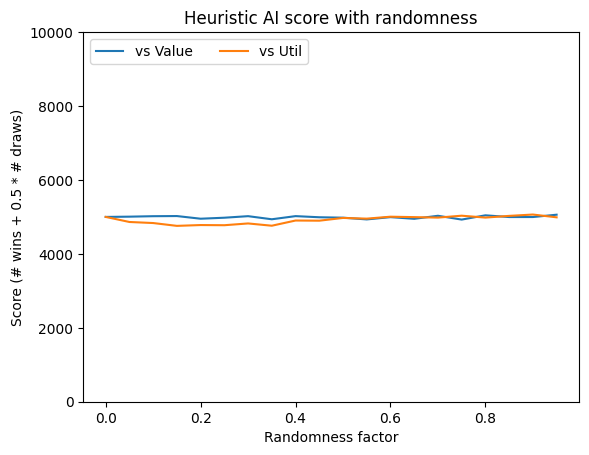

In [106]:
import matplotlib.pyplot as plt 
num_intervals = 20.0
x_arr = np.arange(num_intervals) / num_intervals # randomness settings
vs_value_results, vs_util_results = np.zeros(int(num_intervals)), np.zeros(int(num_intervals))
for i in range(int(num_intervals)):
    test_output = generalization_test(x_arr[i])
    vs_value_results[i] = test_output[1][0] + 0.5 * test_output[1][2]
    vs_util_results[i] = test_output[2][0] + 0.5 * test_output[2][2]

fig, ax = plt.subplots()

# Add some text for labels, title and custom x-axis tick labels, etc.
value_bar = ax.plot(x_arr, vs_value_results, label = "vs Value")
util_bar = ax.plot(x_arr, vs_util_results, label = "vs Util")
ax.set_ylabel('Score (# wins + 0.5 * # draws)')
ax.set_xlabel('Randomness factor')
ax.set_title('Heuristic AI score with randomness')
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0, NUM_GAMES_TABLE)

plt.show()

- Each of the AIs, if playing close to the optimal policy, should be able to score evenly against each other with randomness

Next idea: randomize 20% of outputs/moves that each AI produces

- Prediction: in a utility AI, if we have ~1000 winning states and ~10^6 non-winning states, randomizing 20% of outputs in the AI will destroy it
- While in the value/heuristics AI, the heuristics are "shallower" --> 20% shouldn't be as damaging

In [107]:
# OUTDATED (randomizes the utility AI's moves instead of the minimax function)
AI_NOISE = 0.2
def generalization_test_rand_tables(table_util, table_value, table_heur):
        results_util_vs_value = [0, 0, 0]
        results_heur_vs_value = [0, 0, 0]
        results_heur_vs_util = [0, 0, 0]
        for i in range(NUM_GAMES):
            play_game(results_util_vs_value, table_util, table_value, i)
            play_game(results_heur_vs_value, table_heur, table_value, i)
            play_game(results_heur_vs_util, table_heur, table_util, i)

        return (results_util_vs_value, results_heur_vs_value, results_heur_vs_util)
for j in range(10):
    noise = AI_NOISE * j / 10
    lookup_table_util_rand = generate_lookup_table(find_best_move, noise)
    lookup_table_value_rand = generate_lookup_table(find_best_move_value, noise)
    lookup_table_heur_rand = generate_heuristic_lookup_table(noise)

    print("Generalization test with noise " + str(noise) + ": "
            + str(generalization_test_rand_tables(lookup_table_util_rand, 
            lookup_table_value_rand, lookup_table_heur_rand)))

Generalization test with noise 0.0: ([0, 0, 100], [0, 0, 100], [0, 0, 100])
Generalization test with noise 0.02: ([0, 0, 100], [0, 0, 100], [0, 0, 100])
Generalization test with noise 0.04: ([0, 0, 100], [0, 0, 100], [0, 0, 100])
Generalization test with noise 0.06000000000000001: ([0, 100, 0], [0, 0, 100], [50, 0, 50])
Generalization test with noise 0.08: ([0, 0, 100], [0, 0, 100], [0, 50, 50])
Generalization test with noise 0.1: ([0, 0, 100], [0, 50, 50], [50, 0, 50])
Generalization test with noise 0.12000000000000002: ([0, 50, 50], [0, 0, 100], [0, 0, 100])
Generalization test with noise 0.14: ([0, 50, 50], [0, 0, 100], [0, 0, 100])
Generalization test with noise 0.16: ([50, 0, 50], [50, 0, 50], [50, 0, 50])
Generalization test with noise 0.18: ([0, 50, 50], [0, 0, 100], [50, 50, 0])


Interesting! It seems like inserting noise into each AI doesn't result in a consistent effect (depends on what the noise is).

Let's try randomizing the utility AI's minimax algorithm now. Prediction: this will clearly mess up the utility AI more than the others.

In [108]:
#Reminder: util vs value, heur vs value, heur vs util
def generate_lookup_table_util(find_best_move_alg, randomness = 0.0, move_or_minimax = True):
    """ Generate the lookup table for all valid game states. """
    lookup_table = {}
    for board_str in generate_all_possible_boards():
        if is_valid_board(board_str):
            board = string_to_board(board_str)
            winner = check_winner(board)
            if winner is None:  # Only calculate moves if the game is not already over
                player = 'X' if board_str.count('X') == board_str.count('O') else 'O'
                best_move = find_best_move_alg(board, player, randomness, move_or_minimax)
                lookup_table[board_str] = best_move
    return lookup_table

for j in range(10): #recalculate lookup tables every series of games
    noise = AI_NOISE * j / 10
    lookup_table_util_rand = generate_lookup_table_util(find_best_move, noise, False)
    lookup_table_value_rand = generate_lookup_table(find_best_move_value, noise)
    lookup_table_heur_rand = generate_heuristic_lookup_table(noise)

    print("Generalization test with noise " + str(noise) + ": "
            + str(generalization_test_rand_tables(lookup_table_util_rand, 
            lookup_table_value_rand, lookup_table_heur_rand)))

Generalization test with noise 0.0: ([0, 0, 100], [0, 0, 100], [0, 0, 100])
Generalization test with noise 0.02: ([0, 0, 100], [0, 0, 100], [0, 0, 100])
Generalization test with noise 0.04: ([0, 0, 100], [0, 0, 100], [50, 0, 50])
Generalization test with noise 0.06000000000000001: ([0, 50, 50], [0, 0, 100], [0, 0, 100])
Generalization test with noise 0.08: ([0, 100, 0], [0, 50, 50], [100, 0, 0])
Generalization test with noise 0.1: ([0, 100, 0], [0, 0, 100], [100, 0, 0])
Generalization test with noise 0.12000000000000002: ([0, 50, 50], [0, 50, 50], [0, 0, 100])
Generalization test with noise 0.14: ([0, 100, 0], [100, 0, 0], [50, 0, 50])
Generalization test with noise 0.16: ([0, 100, 0], [0, 50, 50], [100, 0, 0])
Generalization test with noise 0.18: ([50, 0, 50], [0, 0, 100], [0, 50, 50])


Hmm... still doesn't seem like there's a clear trend. Let's try minimax randomization without the lookup table; maybe this will give a clear result against utility AI?

In [110]:
def generalization_test_rand(func_util, func_value, func_heur, randomness = 0.0, move_or_minimax = True):
    results_util_vs_value = [0, 0, 0]
    results_heur_vs_value = [0, 0, 0]
    results_heur_vs_util = [0, 0, 0]
    for i in range(NUM_GAMES):
        play_game(results_util_vs_value, func_util, func_value, i, randomness, move_or_minimax)
        play_game(results_heur_vs_value, func_heur, func_value, i, randomness, move_or_minimax)
        play_game(results_heur_vs_util, func_heur, func_util, i, randomness, move_or_minimax)

    return (results_util_vs_value, results_heur_vs_value, results_heur_vs_util)

for i in range(10):
    randomness = float(i) / 20
    print("Generalization test with randomness = " + str(randomness) + 
          ": " + str(generalization_test_rand(find_best_move, find_best_move_value, 
                                              find_heuristic_move, randomness, False)))

Generalization test with randomness = 0.0: ([0, 0, 100], [0, 0, 100], [0, 0, 100])
Generalization test with randomness = 0.05: ([8, 6, 86], [6, 6, 88], [3, 8, 89])
Generalization test with randomness = 0.1: ([16, 13, 71], [14, 9, 77], [14, 16, 70])
Generalization test with randomness = 0.15: ([18, 20, 62], [13, 16, 71], [20, 21, 59])
Generalization test with randomness = 0.2: ([23, 24, 53], [30, 20, 50], [24, 22, 54])
Generalization test with randomness = 0.25: ([29, 20, 51], [20, 22, 58], [22, 34, 44])
Generalization test with randomness = 0.3: ([37, 29, 34], [25, 33, 42], [28, 29, 43])
Generalization test with randomness = 0.35: ([34, 29, 37], [29, 35, 36], [29, 32, 39])
Generalization test with randomness = 0.4: ([38, 33, 29], [39, 37, 24], [29, 37, 34])
Generalization test with randomness = 0.45: ([37, 41, 22], [27, 41, 32], [40, 37, 23])


Hmm... I thought that, since the utility AI recursively calculates utilities for every future possible position, randomizing minimax would degrade the utility AI's performance much more than the heuristic/value AIs. This clearly didn't turn out to be the case.

In [111]:
# (randomizes the utility AI's minimax to create a new table each game)
# takes a very long time -- 100 games takes ~5 minutes
AI_NOISE = 0.2
def generalization_test_rand_tables(noise):
    results_util_vs_value = [0, 0, 0]
    results_heur_vs_value = [0, 0, 0]
    results_heur_vs_util = [0, 0, 0]
    for i in range(NUM_GAMES):
        table_util = generate_lookup_table(find_best_move, noise, False)
        table_value = generate_lookup_table(find_best_move_value, noise)
        table_heur = generate_heuristic_lookup_table(noise)

        play_game(results_util_vs_value, table_util, table_value, i)
        play_game(results_heur_vs_value, table_heur, table_value, i)
        play_game(results_heur_vs_util, table_heur, table_util, i)
        #print((results_util_vs_value, results_heur_vs_value, results_heur_vs_util))

    return (results_util_vs_value, results_heur_vs_value, results_heur_vs_util)
for j in range(10, 11):
    noise = AI_NOISE * j / 10

    print("Generalization test with noise " + str(noise) + ": "
            + str(generalization_test_rand_tables(noise)))

Generalization test with noise 0.2: ([27, 56, 17], [25, 29, 46], [56, 17, 27])


^ ...this one is actually lopsided! But not very "decisively", though.

In [112]:
print("Generalization test with noise " + str(0.5) + ": "
            + str(generalization_test_rand_tables(0.5)))

Generalization test with noise 0.5: ([40, 50, 10], [39, 32, 29], [59, 34, 7])


I get a similar result to the above when run a number of times on slightly varying versions of the randomization of the minimax algorithm.

So sometimes the minimax algorithm degrades, but only in one case (after generating a lookup table for each round). Why does this happen? Hypotheses:
- Maybe the minimax degradation is more subtle than expected: for instance, if one of the possible moves out of e.g. five in a certain position is given a random value, that just means that you're going to choose the second-best move at worst
    - This will kill you in some situations, like if you need to block a two-in-a-row from the opponent, but in others it's fine
- Maybe the minimax algorithm is able to "deal with" some randomness in its recursion by erasing some defunct values in upstream board positions (with multiple pieces placed)
    - You can get to any "middle" board positions, where the game is not over, multiple ways from states where the game is decided. Thus, in positions like X O X | _ _ _ | X _ O where any move by O still results in a loss, the minimax algorithm is still likely to have one of these positions result in a win for X, thus rating that position as a win for X.
    - Errors might not "stack": suppose we're given a position where there's one winning move, meaning there's a 20% chance the minimax AI will rate it incorrectly. Then in the position one move prior, it *might* miss its only winning path as a result, or it might find another winning path
- In other words: if tic-tac-toe is not very "path-dependent", and there are multiple ways to play optimally from most positions, then errors will not propagate very far
    - This is somewhat surprising, but sounds plausible
- Another point: the heuristic and value AIs were not actually *that* much simpler than the utility AI, at least in terms of lines of code
    - So maybe we shouldn't expect as much of a generalization difference